In [2]:
!pip install torch_geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 18.8 MB/s eta 0:00:00


Processing...
Done!


Epoch: 000, Loss: 1.9993, Train: 0.5643, Val: 0.3880, Test: 0.4410
Epoch: 010, Loss: 1.0673, Train: 0.9357, Val: 0.7600, Test: 0.7630
Epoch: 020, Loss: 0.9472, Train: 0.9786, Val: 0.7680, Test: 0.7830
Epoch: 030, Loss: 0.7020, Train: 0.9786, Val: 0.7700, Test: 0.7890
Epoch: 040, Loss: 0.6142, Train: 0.9857, Val: 0.7780, Test: 0.8060
Epoch: 050, Loss: 0.5171, Train: 0.9929, Val: 0.7760, Test: 0.7950
Epoch: 060, Loss: 0.5275, Train: 0.9929, Val: 0.7720, Test: 0.7890
Epoch: 070, Loss: 0.5396, Train: 1.0000, Val: 0.7780, Test: 0.8030
Epoch: 080, Loss: 0.4822, Train: 1.0000, Val: 0.7720, Test: 0.8020
Epoch: 090, Loss: 0.4585, Train: 1.0000, Val: 0.7740, Test: 0.7970
Epoch: 100, Loss: 0.4481, Train: 1.0000, Val: 0.7780, Test: 0.8020
Epoch: 110, Loss: 0.4617, Train: 1.0000, Val: 0.7840, Test: 0.8030
Epoch: 120, Loss: 0.3190, Train: 1.0000, Val: 0.7780, Test: 0.8000
Epoch: 130, Loss: 0.3719, Train: 1.0000, Val: 0.7700, Test: 0.7930
Epoch: 140, Loss: 0.4069, Train: 1.0000, Val: 0.7740, Test: 0.

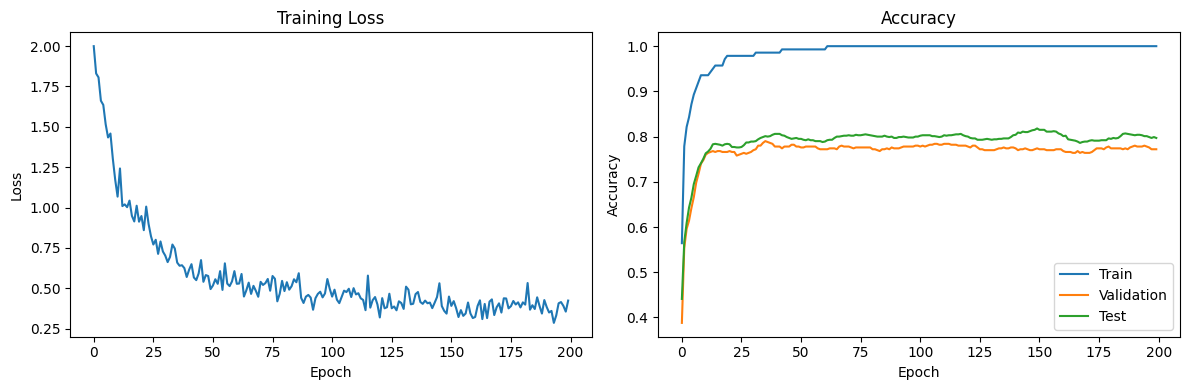

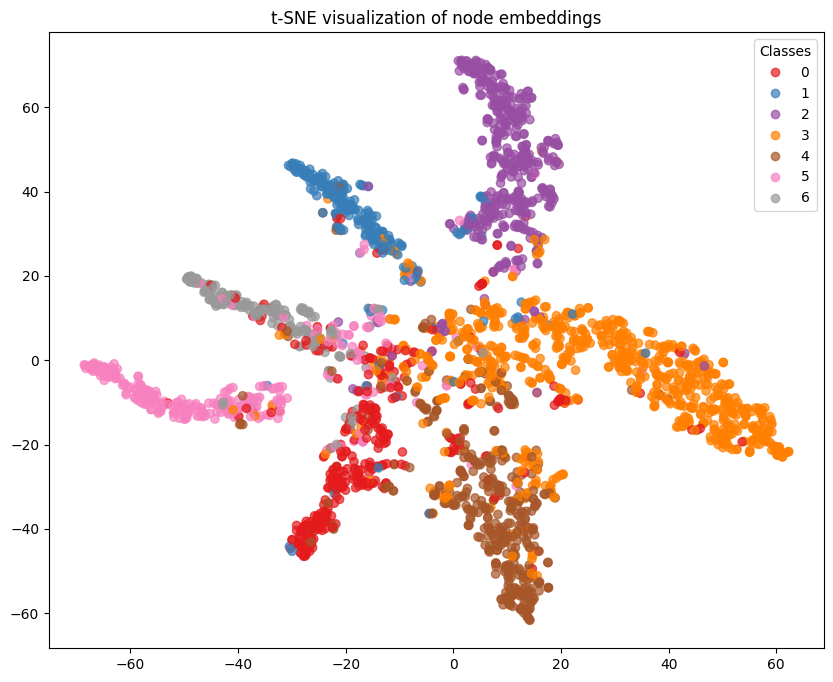

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GATConv
from torch_geometric.datasets import Planetoid
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

# Загрузка датасета (Cora, Citeseer или Pubmed)
dataset = Planetoid(root='/tmp/Cora', name='Cora')
data = dataset[0]

# Определение модели GAT
class GAT(nn.Module):
    def __init__(self, num_features, num_classes, hidden_dim=8, num_heads=8, dropout=0.6):
        super(GAT, self).__init__()
        self.dropout = dropout

        # Первый GAT слой (multiple heads)
        self.conv1 = GATConv(num_features, hidden_dim, heads=num_heads, dropout=dropout)

        # Второй GAT слой (single head для классификации)
        self.conv2 = GATConv(hidden_dim * num_heads, num_classes, heads=1, concat=False, dropout=dropout)

    def forward(self, x, edge_index):
        # Применяем dropout к входным признакам
        x = F.dropout(x, p=self.dropout, training=self.training)

        # Первый GAT слой
        x = self.conv1(x, edge_index)
        x = F.elu(x)  # Активация ELU
        x = F.dropout(x, p=self.dropout, training=self.training)

        # Второй GAT слой
        x = self.conv2(x, edge_index)

        return F.log_softmax(x, dim=1)  # Логарифмический softmax для потерь NLL

# Инициализация модели
model = GAT(num_features=dataset.num_features,
            num_classes=dataset.num_classes)

# Перемещение модели и данных на устройство (GPU если доступно)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
data = data.to(device)

# Оптимизатор
optimizer = torch.optim.Adam(model.parameters(), lr=0.005, weight_decay=5e-4)

# Функция для обучения
def train():
    model.train()
    optimizer.zero_grad()
    out = model(data.x, data.edge_index)
    loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    return loss.item()

# Функция для тестирования
def test():
    model.eval()
    with torch.no_grad():
        out = model(data.x, data.edge_index)
        pred = out.argmax(dim=1)

        # Вычисление точности для train, val и test наборов
        train_correct = pred[data.train_mask] == data.y[data.train_mask]
        train_acc = int(train_correct.sum()) / int(data.train_mask.sum())

        val_correct = pred[data.val_mask] == data.y[data.val_mask]
        val_acc = int(val_correct.sum()) / int(data.val_mask.sum())

        test_correct = pred[data.test_mask] == data.y[data.test_mask]
        test_acc = int(test_correct.sum()) / int(data.test_mask.sum())

    return train_acc, val_acc, test_acc

# Обучение модели
losses = []
train_accs, val_accs, test_accs = [], [], []
for epoch in range(200):
    loss = train()
    losses.append(loss)
    train_acc, val_acc, test_acc = test()
    train_accs.append(train_acc)
    val_accs.append(val_acc)
    test_accs.append(test_acc)

    if epoch % 10 == 0:
        print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Train: {train_acc:.4f}, Val: {val_acc:.4f}, Test: {test_acc:.4f}')

# Визуализация обучения
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(losses)
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.subplot(1, 2, 2)
plt.plot(train_accs, label='Train')
plt.plot(val_accs, label='Validation')
plt.plot(test_accs, label='Test')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.tight_layout()
plt.show()

# Визуализация эмбеддингов с помощью t-SNE
def visualize_embeddings():
    model.eval()
    with torch.no_grad():
        out = model(data.x, data.edge_index)
        embeddings = out.cpu().numpy()

    # Применяем t-SNE для уменьшения размерности до 2D
    tsne = TSNE(n_components=2, random_state=42)
    embeddings_2d = tsne.fit_transform(embeddings)

    # Визуализация
    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=data.y.cpu(), cmap='Set1', alpha=0.7)
    plt.legend(*scatter.legend_elements(), title="Classes")
    plt.title('t-SNE visualization of node embeddings')
    plt.show()

visualize_embeddings()